<h3><center>State and Measurement equation for UKF ...</center></h3>

$$ x_{k+1} = \sqrt{x_k + 5} + w_k $$
$$ y_k = x_k^3 + v_k $$
$$ \sum\tilde{x}_{\mathrm{true}}=1\sum{\tilde{w}}=0.1 \sum{\tilde{v}}=0.1 $$

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.linalg import cholesky, inv, sqrtm, block_diag
from scipy import stats
import seaborn as sns

In [57]:
Nx=1 # Number of states
Nxa=3 # Augmented number of states
Ny=1 # Number of measurements
h=np.sqrt(3) # scaling parameter
inv_2h2 = 1 / (2 * h**2) # 1/(2*h^2)
Wmx=np.array([0]) # Wmx0 = (h**2-Nxa) / (h**2) which is essentially 0 for Nxa=3, h=sqrt(3)
Wmx=np.append(Wmx,[inv_2h2]*(2*Nxa)) # Wmxi = 1/(2*h^2) for i=1,...,2*Nxa
rtWmx=np.sqrt(Wmx)

In [58]:
SigmaW=.1 # Process noise standard deviation
SigmaV=.1 # Measurement noise standard deviation
maxIter=4000 # Number of iterations
xtrue=2+np.random.normal(0,1) # Initial true state
xhat=0 # Initial state estimate
# print(xhat)
Sigmax=1 # Initial state covariance estimate

In [59]:
xstore=np.zeros(maxIter+1) # Store true states
xstore[0]=xtrue
xhatstore=np.zeros(maxIter+1) # Store state estimates
xhatstore[0]=xhat
Sigmaxstore=np.zeros(maxIter+1) # Store state covariance estimates
Sigmaxstore[0]=Sigmax
# print(xhat)
# print(np.array([xhat]))

In [60]:
# print(xhat)
for k in range(maxIter):
    # print(k)
    # print(xhat)
    xhata=np.array(xhat)
    # print(xhata)
    xhata=np.append(xhata,[0,0]).reshape(-1,1) # Augmented state vector
    # print(xhata)
    Sigmaxa=block_diag(Sigmax,SigmaW,SigmaV) # Augmented state covariance
    # print(Sigmaxa)
    #cholesky decomposition with lower triangular matrix
    try: #robustness for non-positive definite matrix
        sSigmaxa = cholesky(Sigmaxa, lower=True) 
    except np.linalg.LinAlgError:
        sSigmaxa = np.eye(Sigmaxa.shape[0]) * 1e-6  # fallback
    # print(sSigmaxa)
    #calculate sigma points
    X=np.zeros((Nxa,2*Nxa+1)) # Sigma points matrix
    X[:,0]=xhata[:,0] # First sigma point
    for i in range(Nxa):
        X[:,i+1]=xhata[:,0]+h*sSigmaxa[:,i] # Sigma points for xhat + h*sqrt(Sigmaxa)
        X[:,i+1+Nxa]=xhata[:,0]-h*sSigmaxa[:,i] # Sigma points for xhat - h*sqrt(Sigmaxa)
    Xx=np.sqrt(5+X[0,:])+X[1,:] # Propagate sigma points through state equation
    result=np.sum(Wmx*Xx) # Predicted state mean
    # print(result)
    xhat=result
    Xs=(Xx-xhat)*rtWmx 
    Sigmax=np.sum(Xs**2) # Predicted state covariance
    # print(result1)
    w=np.random.normal(0,math.sqrt(SigmaW)) # Process noise
    v=np.random.normal(0,math.sqrt(SigmaV)) # Measurement noise
    ytrue=xtrue**3+v # True measurement
    xtrue=math.sqrt(5+xtrue)+w # True state
    
    # Y=[Xx[i]**3+X[2,i] for i in range(len(Xx))] # old way
    Y=Xx**3+X[2,:] # Propagate sigma points through measurement equation
    # print(Y)
    result2=np.sum(Wmx*Y)
    yhat=result2 # Predicted measurement mean
    # print(yhat)
    #Ys=np.array([((Y-yhat)*rtWmx) for i in range(len(Y))]) # old way
    Ys=(Y-yhat)*rtWmx
    result2=np.sum(Ys**2)
    SigmaY=result2 # Predicted measurement covariance
    # print(result2)
    # print(len(Xs),len(Ys))
    SigmaXY=np.sum(Xs*Ys) # Cross covariance between state and measurement
    # print(SigmaXY)
    K=SigmaXY/SigmaY # Kalman gain
    # print(K)
    xhat=xhat+K*(ytrue-yhat) # Updated state estimate
    Sigmax=Sigmax-K*SigmaY*K # Updated state covariance estimate
    xstore[k+1]=xtrue # Store true state
    xhatstore[k+1]=xhat # Store state estimate
    Sigmaxstore[k+1]=Sigmax # Store state covariance estimate


Residual Mean: 0.0007856373807086092
Residual Std Dev: 0.4146752591349065
Residual Skewness: -0.12233079431668333
Residual Kurtosis: 0.8236005322461741
mean xstore: 2.792557475436525
mean xhatstore: 2.791771838055817
mean Sigmaxstore: 0.0028622417558700724


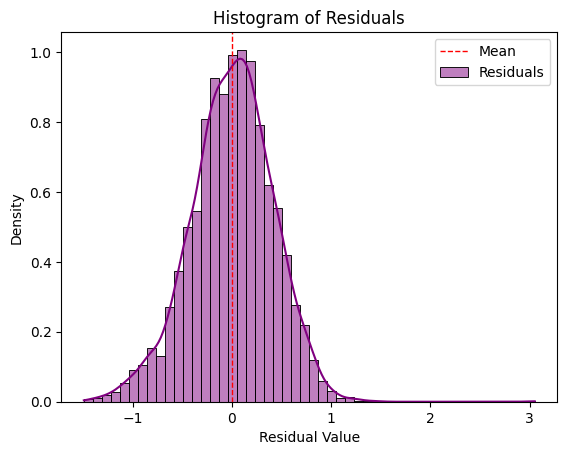

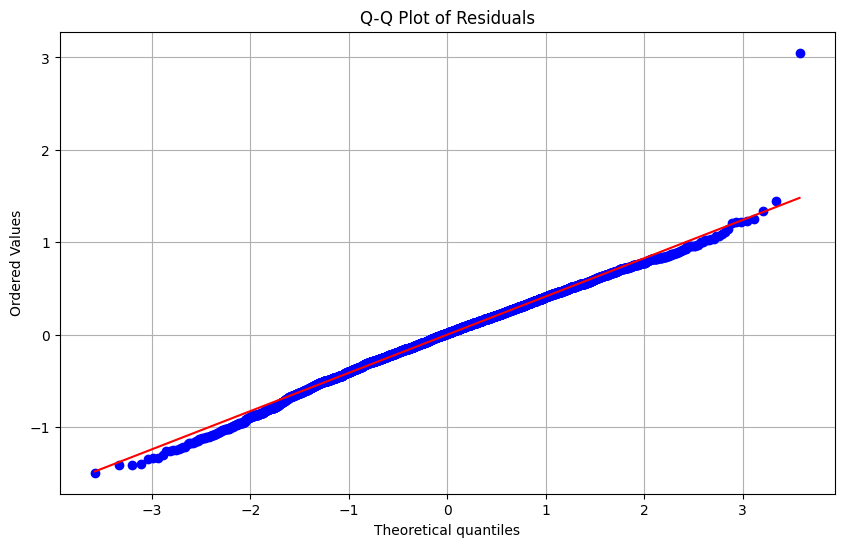

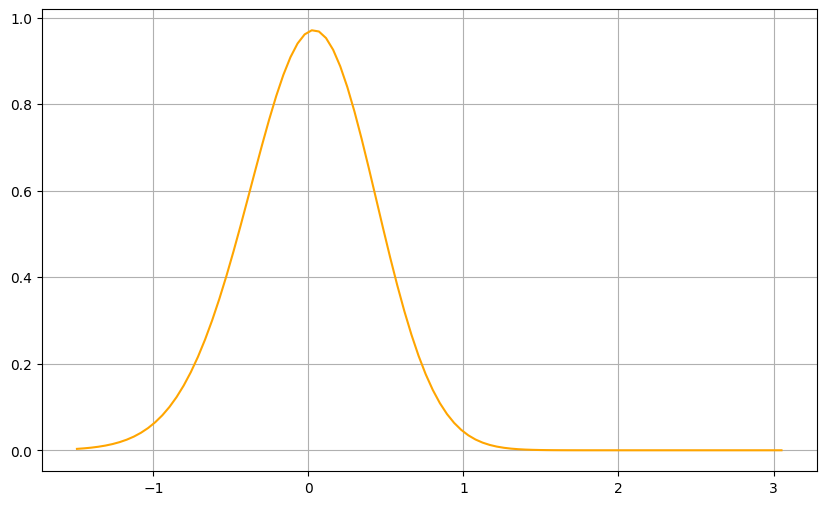

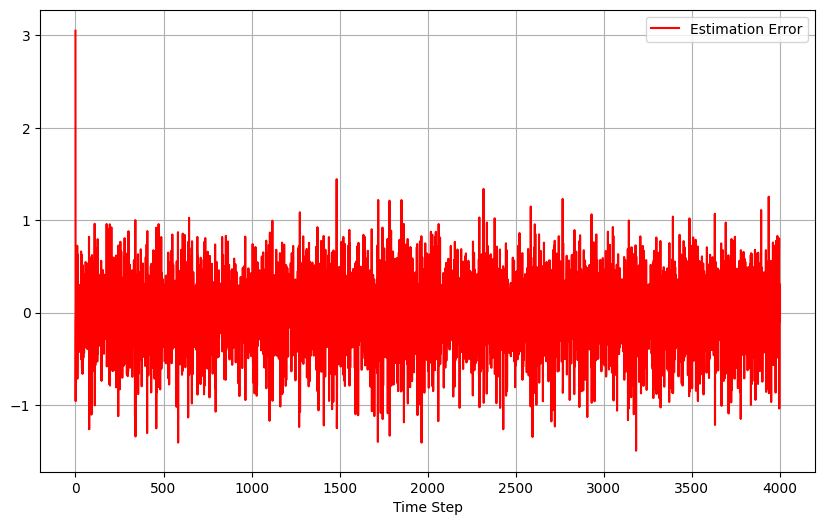

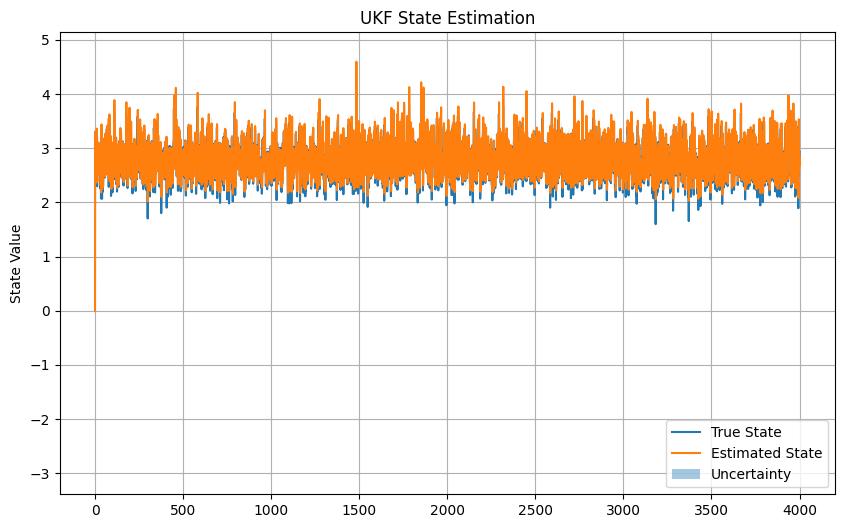

In [61]:

xresidual=xstore-xhatstore
resmean=np.mean(xresidual)
resstd=np.std(xresidual)
resskew=stats.skew(xresidual)
reskurt=stats.kurtosis(xresidual)
meanxstore=np.mean(xstore)
meanxhatstore=np.mean(xhatstore)
meanSigmaxstore=np.mean(Sigmaxstore)
print('Residual Mean:', resmean)
print('Residual Std Dev:', resstd)
print('Residual Skewness:', resskew)
print('Residual Kurtosis:', reskurt)
print(f"mean xstore: {meanxstore}")
print(f"mean xhatstore: {meanxhatstore}")
print(f"mean Sigmaxstore: {meanSigmaxstore}")

plt.figure()
sns.histplot(xresidual,kde=True, stat="density",bins=50,color='purple', edgecolor='black', label='Residuals')
plt.axvline(resmean, color='red', linestyle='dashed', linewidth=1, label='Mean')
plt.title('Histogram of Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Density')
plt.legend()

plt.figure(figsize=(10,6))
stats.probplot(xresidual, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
params = stats.skewnorm.fit(xresidual)
x = np.linspace(min(xresidual), max(xresidual), 100)
pdf = stats.skewnorm.pdf(x, *params)
plt.plot(x, pdf, label="Fitted Skew-Normal", color='orange')
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.plot(xresidual,label='Estimation Error',color='red')
plt.xlabel('Time Step')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(xstore,label='True State')
plt.plot(xhatstore,label='Estimated State')
plt.fill_between(np.arange(len(Sigmaxstore)),xhatstore-3*np.sqrt(Sigmaxstore),xhatstore+3*np.sqrt(Sigmaxstore),alpha=0.4,label='Uncertainty')
plt.ylabel('State Value')
plt.title('UKF State Estimation')
plt.legend()
plt.grid()
plt.show()
